In [1]:
import jax
import jax.numpy as jnp


train_x = jnp.array([-0.8, -0.75, 0.0, 0.05, 0.07, 0.7, 0.73])
train_y = jnp.cos(train_x)**2 + 0.01*jax.random.normal(jax.random.PRNGKey(0), train_x.shape)

2024-05-08 15:44:55.505359: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
polyfit_coeffs = jnp.polyfit(train_x, train_y, deg=3)
eval_x = jnp.linspace(-1, 1, 1000)

def evaluate(polyfit_coeffs, x):
    return jnp.polyval(polyfit_coeffs, x)

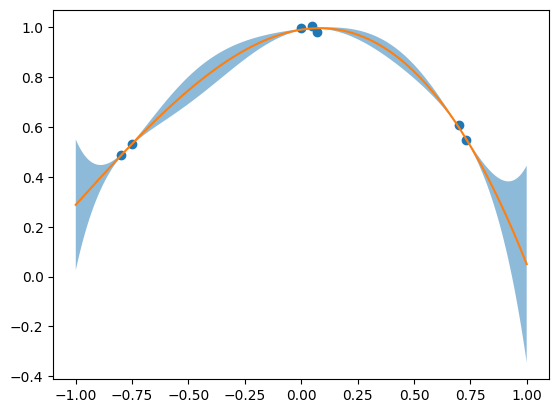

In [3]:
import matplotlib.pyplot as plt

eval_y_pol = evaluate(polyfit_coeffs, eval_x)

plt.plot(train_x, train_y, "o")
plt.plot(eval_x, eval_y_pol)

X = jnp.vander(train_x, N=4)
XTX = X.T @ X

gradients = jax.jacrev(evaluate)(polyfit_coeffs, eval_x)

def calculate_uncertainties(XTX, gradients):
    return gradients @ jnp.linalg.solve(XTX, gradients)

uncertainties_pol = 0.005 * jax.vmap(calculate_uncertainties, in_axes=(None, 0))(XTX, gradients)

plt.fill_between(eval_x, eval_y_pol - uncertainties_pol, eval_y_pol + uncertainties_pol, alpha=0.5)

plt.show()

In [4]:
def gaussian(params, x):
    a, b, c, d, e, f = params
    return a * jnp.exp(-((x - b) / c)**2) + d * jnp.exp(-((x - e) / f)**2)

def loss_fn(params):
    loss = jnp.mean((gaussian(params, train_x) - train_y)**2)
    return loss

import jaxopt

params = jnp.array([1.0, 0.015, 1.0, 1.0, -0.015, 1.0])  # break symmetry

optimizer = jaxopt.LBFGS(jax.value_and_grad(loss_fn), value_and_grad=True)
state = optimizer.init_state(params)
for i in range(100):
    if i % 10 == 0:
        print("step:", i, "loss:", loss_fn(params))
    params, state = optimizer.update(params, state)


step: 0 loss: 0.6390602
step: 10 loss: 0.0001017535
step: 20 loss: 0.00010172348
step: 30 loss: 0.00010167414
step: 40 loss: 0.00010148679
step: 50 loss: 0.000101006946
step: 60 loss: 0.000100305035
step: 70 loss: 9.9535704e-05
step: 80 loss: 9.8620214e-05
step: 90 loss: 9.606734e-05


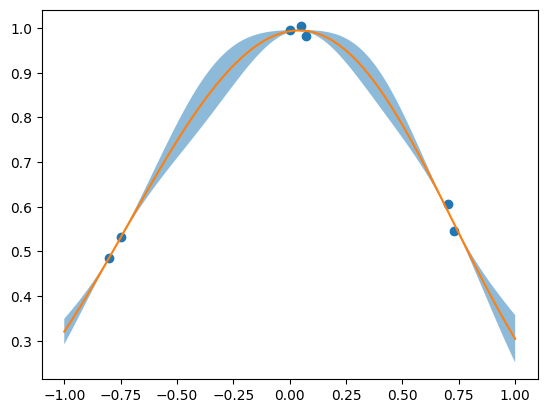

In [5]:
import matplotlib.pyplot as plt

eval_y_gauss = gaussian(params, eval_x)

plt.plot(train_x, train_y, "o")
plt.plot(eval_x, eval_y_gauss)

inv_covariance = jax.hessian(loss_fn)(params)

gradients = jax.jacrev(gaussian)(params, eval_x)

uncertainties_gauss = 0.001 * jax.vmap(calculate_uncertainties, in_axes=(None, 0))(inv_covariance, gradients)

plt.fill_between(eval_x, eval_y_gauss - uncertainties_gauss, eval_y_gauss + uncertainties_gauss, alpha=0.5)

plt.show()



In [6]:
import equinox as eqx
import optax

In [7]:
model = eqx.nn.MLP(in_size=1, out_size=1, width_size=32, depth=2, activation=jax.nn.silu, key=jax.random.PRNGKey(0))
# print(model)

optimizer = optax.adamw(1e-2)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

def loss_fn(model, x, y):
    return jnp.mean((jax.vmap(model)(x) - y)**2)

grad_loss_fn = eqx.filter_jit(eqx.filter_value_and_grad(loss_fn))

def train_step(model, opt_state, train_x, train_y):
    loss, grads = grad_loss_fn(model, train_x, train_y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

for epoch in range(1000):
    loss, model, opt_state = train_step(model, opt_state, train_x[:, None], train_y[:, None])
    if epoch % 100 == 0:
        print("loss:", loss)

loss: 0.7442067
loss: 0.00011866299
loss: 0.000102285696
loss: 9.599976e-05
loss: 9.1535374e-05
loss: 8.7094326e-05
loss: 8.220193e-05
loss: 7.836572e-05
loss: 7.6317796e-05
loss: 7.32265e-05


In [8]:
def last_layer_model(x):
    x = model.layers[0](x)
    x = jax.nn.silu(x)
    x = model.layers[1](x)
    x = jax.nn.silu(x)
    return x

X = jax.vmap(last_layer_model)(train_x[:, None])

# check that the predictions match
assert jnp.allclose(jax.vmap(model.layers[2])(X), jax.vmap(model)(train_x[:, None]))

# Append bias
X = jnp.concatenate([X, jnp.ones((X.shape[0], 1))], axis=1)
XTX = X.T @ X + 1e-3 * jnp.eye(33)

In [9]:
eval_y_nn = jax.vmap(model)(eval_x[:, None])[:, 0]

def calculate_uncertainties(XTX, gradients):
    return gradients @ jnp.linalg.solve(XTX, gradients)

ll_features_x = jnp.concatenate([jax.vmap(last_layer_model)(eval_x[:, None]), jnp.ones((eval_x.shape[0], 1))], axis=1)
uncertainties_nn = 0.02 * jax.vmap(calculate_uncertainties, in_axes=(None, 0))(XTX, ll_features_x)

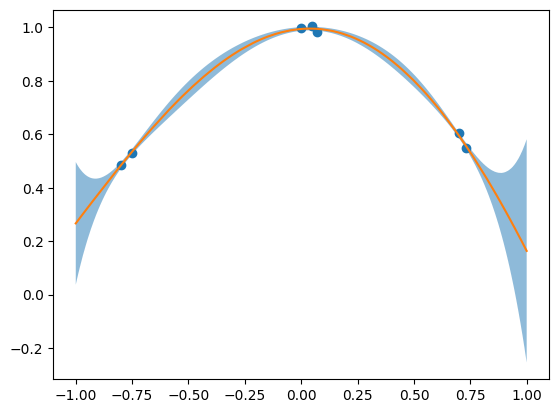

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_x, train_y, "o")
plt.plot(eval_x, eval_y_nn)
plt.fill_between(eval_x, eval_y_nn - uncertainties_nn, eval_y_nn + uncertainties_nn, alpha=0.5)
plt.show()

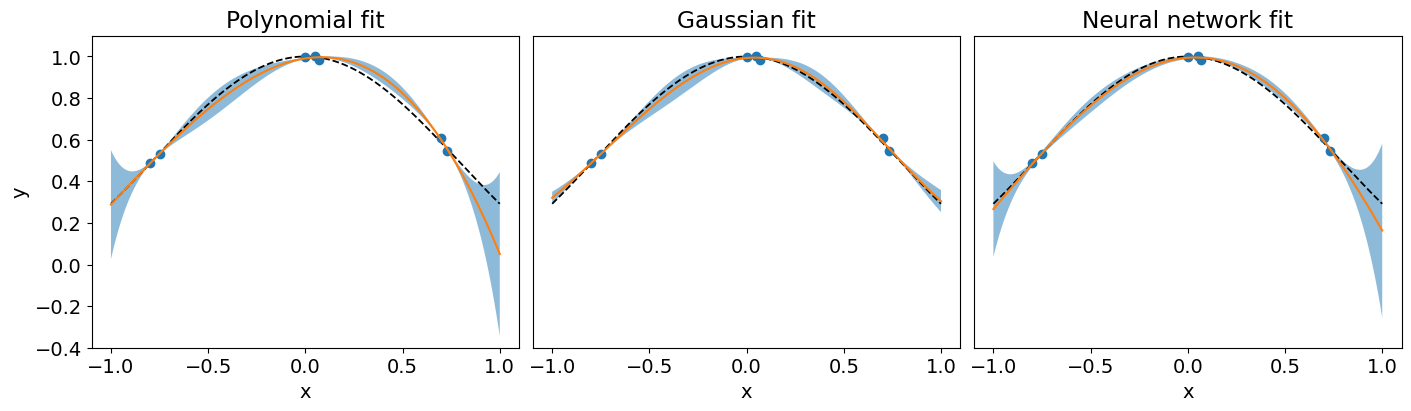

In [21]:
# Plot the three side-by-side

plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(14, 4), constrained_layout=True)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(eval_x, jnp.cos(eval_x)**2, "--", linewidth=1.3, color="black")
ax1.plot(train_x, train_y, "o")
ax1.plot(eval_x, eval_y_pol)
ax1.fill_between(eval_x, eval_y_pol - uncertainties_pol, eval_y_pol + uncertainties_pol, alpha=0.5)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Polynomial fit")
ax1.set_ylim(-0.4, 1.1)

ax2.plot(eval_x, jnp.cos(eval_x)**2, "--", linewidth=1.3, color="black")
ax2.plot(train_x, train_y, "o")
ax2.plot(eval_x, eval_y_gauss)
ax2.fill_between(eval_x, eval_y_gauss - uncertainties_gauss, eval_y_gauss + uncertainties_gauss, alpha=0.5)
ax2.set_yticks([])
ax2.set_xlabel("x")
ax2.set_title("Gaussian fit")
ax2.set_ylim(-0.4, 1.1)

ax3.plot(eval_x, jnp.cos(eval_x)**2, "--", linewidth=1.3, color="black")
ax3.plot(train_x, train_y, "o")
ax3.plot(eval_x, eval_y_nn)
ax3.fill_between(eval_x, eval_y_nn - uncertainties_nn, eval_y_nn + uncertainties_nn, alpha=0.5)
ax3.set_yticks([])
ax3.set_xlabel("x")
ax3.set_title("Neural network fit")
ax3.set_ylim(-0.4, 1.1)

plt.savefig("toy_fit_comparison.pdf")
plt.show()